In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import multi_gpu_model

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1,2'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_ch_32_DO(conv_num=1):
    kernel_size = 64
    filter_size = 128
    
    model=Sequential()
    model.add(Conv1D (kernel_size=3*kernel_size, filters=filter_size, strides=1, 
                      padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        target_kernel_size = 3 * (kernel_size//(2**(i+1)))
        model.add(Conv1D (kernel_size=target_kernel_size if target_kernel_size != 0 else 3, 
                          filters=filter_size*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(3, 10):
    model = build_1d_cnn_custom_ch_32_DO(conv_num=i)
#     model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7619 - acc: 0.4333
Epoch 00001: val_loss improved from inf to 1.22989, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_3_conv_checkpoint/001-1.2299.hdf5
36805/36805 [==============================] - 275s 7ms/sample - loss: 1.7618 - acc: 0.4334 - val_loss: 1.2299 - val_acc: 0.6033
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0510 - acc: 0.6781
Epoch 00002: val_loss improved from 1.22989 to 0.84152, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_3_conv_checkpoint/002-0.8415.hdf5
36805/36805 [==============================] - 272s 7ms/sample - loss: 1.0509 - acc: 0.6781 - val_loss: 0.8415 - val_acc: 0.7482
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7823 - acc: 0.7667
Epoch 00003: val_loss improved from 0.84152 t

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0381 - acc: 0.9903
Epoch 00027: val_loss did not improve from 0.60228
36805/36805 [==============================] - 270s 7ms/sample - loss: 0.0381 - acc: 0.9903 - val_loss: 1.1899 - val_acc: 0.8185
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0413 - acc: 0.9896
Epoch 00028: val_loss did not improve from 0.60228
36805/36805 [==============================] - 268s 7ms/sample - loss: 0.0413 - acc: 0.9896 - val_loss: 1.1380 - val_acc: 0.8318
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0278 - acc: 0.9936
Epoch 00029: val_loss did not improve from 0.60228
36805/36805 [==============================] - 269s 7ms/sample - loss: 0.0278 - acc: 0.9936 - val_loss: 1.0964 - val_acc: 0.8402
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0329 - acc: 0.9915
Epoch 00030: val_loss did not improve from 0.60228
36805/36805 [========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0225 - acc: 0.9951
Epoch 00057: val_loss did not improve from 0.60228
36805/36805 [==============================] - 270s 7ms/sample - loss: 0.0225 - acc: 0.9951 - val_loss: 1.3055 - val_acc: 0.8381

1D_CNN_custom_kernel_192_ch_128_DO_3_conv Model


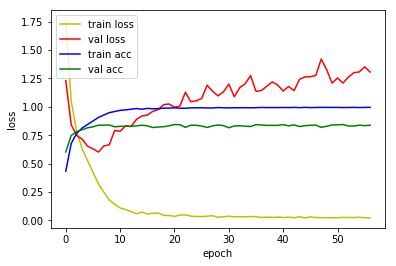

4815/4815 [==============================] - 12s 3ms/sample - loss: 0.6562 - acc: 0.8089
Loss: 0.6561945490995548 Accuracy: 0.8089304

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8249 - acc: 0.4060
Epoch 00001: val_loss improved from inf to 1.31919, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_4_conv_checkpoint/001-1.3192.hdf5
36805/36805 [==============================] - 259s 7ms/sample - loss: 1.8248 - acc: 0.4060 - val_loss: 1.3192 - val_acc: 0.5837
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2346 - acc: 0.6068
Epoch 00002: val_loss improved from 1.31919 to 1.09554, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_4_conv_checkpoint/002-1.0955.hdf5
36805/36805 [==============================] - 305s 8ms/sample - loss: 1.2346 - acc: 0.6068 - val_loss: 1.0955 - val_acc: 0.6560
Epoch 3/500
36800/36805 [============================>

36800/36805 [============================>.] - ETA: 0s - loss: 0.0454 - acc: 0.9865
Epoch 00027: val_loss did not improve from 0.47359
36805/36805 [==============================] - 256s 7ms/sample - loss: 0.0454 - acc: 0.9865 - val_loss: 0.6613 - val_acc: 0.8894
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0597 - acc: 0.9822
Epoch 00028: val_loss did not improve from 0.47359
36805/36805 [==============================] - 307s 8ms/sample - loss: 0.0597 - acc: 0.9822 - val_loss: 0.7659 - val_acc: 0.8707
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0572 - acc: 0.9829
Epoch 00029: val_loss did not improve from 0.47359
36805/36805 [==============================] - 258s 7ms/sample - loss: 0.0572 - acc: 0.9829 - val_loss: 0.6975 - val_acc: 0.8877
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0446 - acc: 0.9874
Epoch 00030: val_loss did not improve from 0.47359
36805/36805 [=====================

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0258 - acc: 0.9932
Epoch 00057: val_loss did not improve from 0.47359
36805/36805 [==============================] - 258s 7ms/sample - loss: 0.0258 - acc: 0.9932 - val_loss: 0.8809 - val_acc: 0.8735
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0290 - acc: 0.9926
Epoch 00058: val_loss did not improve from 0.47359
36805/36805 [==============================] - 307s 8ms/sample - loss: 0.0290 - acc: 0.9926 - val_loss: 0.8105 - val_acc: 0.8838
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0213 - acc: 0.9946
Epoch 00059: val_loss did not improve from 0.47359
36805/36805 [==============================] - 258s 7ms/sample - loss: 0.0213 - acc: 0.9946 - val_loss: 0.8979 - val_acc: 0.8814

1D_CNN_custom_kernel_192_ch_128_DO_4_conv Model


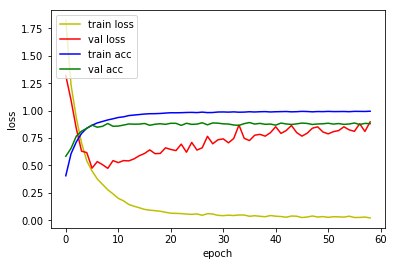

4815/4815 [==============================] - 13s 3ms/sample - loss: 0.5587 - acc: 0.8528
Loss: 0.5587189676234284 Accuracy: 0.8527518

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9195 - acc: 0.3707
Epoch 00001: val_loss improved from inf to 1.29115, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_5_conv_checkpoint/001-1.2911.hdf5
36805/36805 [==============================] - 283s 8ms/sample - loss: 1.9194 - acc: 0.3707 - val_loss: 1.2911 - val_acc: 0.5758
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2217 - acc: 0.6090
Epoch 00002: val_loss improved from 1.29115 to 0.99196, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_5_conv_checkpoint/002-0.9920.hdf5
36805/36805 [==============================] - 282s 8ms/sample - loss: 1.2217 - acc: 0.6090 - val_loss: 0.9920 - val_acc: 0.6997
Epoch 3/500
36800/36805 [============================>

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0541 - acc: 0.9833
Epoch 00027: val_loss did not improve from 0.35492
36805/36805 [==============================] - 281s 8ms/sample - loss: 0.0541 - acc: 0.9833 - val_loss: 0.5035 - val_acc: 0.9089
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0508 - acc: 0.9840
Epoch 00028: val_loss did not improve from 0.35492
36805/36805 [==============================] - 281s 8ms/sample - loss: 0.0508 - acc: 0.9841 - val_loss: 0.5095 - val_acc: 0.9059
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0567 - acc: 0.9819
Epoch 00029: val_loss did not improve from 0.35492
36805/36805 [==============================] - 280s 8ms/sample - loss: 0.0567 - acc: 0.9819 - val_loss: 0.5062 - val_acc: 0.9115
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0503 - acc: 0.9854
Epoch 00030: val_loss did not improve from 0.35492
36805/36805 [========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0335 - acc: 0.9906
Epoch 00057: val_loss did not improve from 0.35492
36805/36805 [==============================] - 278s 8ms/sample - loss: 0.0335 - acc: 0.9906 - val_loss: 0.6067 - val_acc: 0.9094
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0279 - acc: 0.9918
Epoch 00058: val_loss did not improve from 0.35492
36805/36805 [==============================] - 277s 8ms/sample - loss: 0.0279 - acc: 0.9918 - val_loss: 0.6103 - val_acc: 0.9094
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0230 - acc: 0.9937
Epoch 00059: val_loss did not improve from 0.35492
36805/36805 [==============================] - 279s 8ms/sample - loss: 0.0230 - acc: 0.9937 - val_loss: 0.5572 - val_acc: 0.9199
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0278 - acc: 0.9917
Epoch 00060: val_loss did not improve from 0.35492
36805/36805 [========

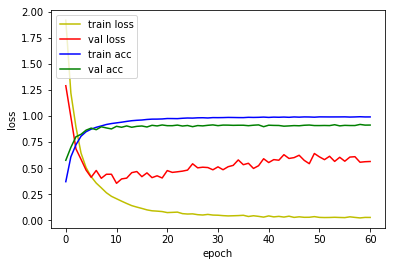

4815/4815 [==============================] - 13s 3ms/sample - loss: 0.4415 - acc: 0.8804
Loss: 0.4415106275618881 Accuracy: 0.88037384

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9964 - acc: 0.3423
Epoch 00001: val_loss improved from inf to 1.37711, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_6_conv_checkpoint/001-1.3771.hdf5
36805/36805 [==============================] - 283s 8ms/sample - loss: 1.9964 - acc: 0.3423 - val_loss: 1.3771 - val_acc: 0.5595
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2590 - acc: 0.5882
Epoch 00002: val_loss improved from 1.37711 to 1.02280, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_6_conv_checkpoint/002-1.0228.hdf5
36805/36805 [==============================] - 281s 8ms/sample - loss: 1.2590 - acc: 0.5882 - val_loss: 1.0228 - val_acc: 0.6904
Epoch 3/500
36800/36805 [============================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0866 - acc: 0.9708
Epoch 00025: val_loss did not improve from 0.25489
36805/36805 [==============================] - 280s 8ms/sample - loss: 0.0866 - acc: 0.9708 - val_loss: 0.2995 - val_acc: 0.9331
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0738 - acc: 0.9747
Epoch 00026: val_loss did not improve from 0.25489
36805/36805 [==============================] - 280s 8ms/sample - loss: 0.0738 - acc: 0.9747 - val_loss: 0.3543 - val_acc: 0.9250
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0736 - acc: 0.9754
Epoch 00027: val_loss did not improve from 0.25489
36805/36805 [==============================] - 276s 8ms/sample - loss: 0.0736 - acc: 0.9754 - val_loss: 0.3539 - val_acc: 0.9304
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0665 - acc: 0.9776
Epoch 00028: val_loss did not improve from 0.25489
36805/36805 [=====================

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0366 - acc: 0.9885
Epoch 00055: val_loss did not improve from 0.25489
36805/36805 [==============================] - 280s 8ms/sample - loss: 0.0366 - acc: 0.9885 - val_loss: 0.3980 - val_acc: 0.9306
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0327 - acc: 0.9894
Epoch 00056: val_loss did not improve from 0.25489
36805/36805 [==============================] - 279s 8ms/sample - loss: 0.0326 - acc: 0.9894 - val_loss: 0.4229 - val_acc: 0.9341
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0324 - acc: 0.9900
Epoch 00057: val_loss did not improve from 0.25489
36805/36805 [==============================] - 279s 8ms/sample - loss: 0.0324 - acc: 0.9900 - val_loss: 0.4465 - val_acc: 0.9294
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0376 - acc: 0.9884
Epoch 00058: val_loss did not improve from 0.25489
36805/36805 [========

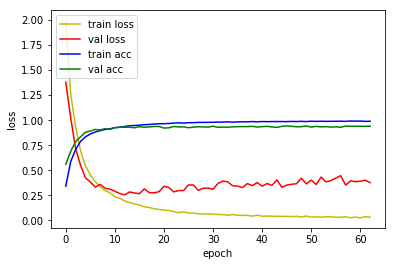

4815/4815 [==============================] - 14s 3ms/sample - loss: 0.3166 - acc: 0.9134
Loss: 0.3166494057804872 Accuracy: 0.91339564

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1633 - acc: 0.2761
Epoch 00001: val_loss improved from inf to 1.50384, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_7_conv_checkpoint/001-1.5038.hdf5
36805/36805 [==============================] - 284s 8ms/sample - loss: 2.1633 - acc: 0.2761 - val_loss: 1.5038 - val_acc: 0.5313
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3374 - acc: 0.5670
Epoch 00002: val_loss improved from 1.50384 to 1.11412, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_7_conv_checkpoint/002-1.1141.hdf5
36805/36805 [==============================] - 284s 8ms/sample - loss: 1.3376 - acc: 0.5669 - val_loss: 1.1141 - val_acc: 0.6497
Epoch 3/500
36800/36805 [============================

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0982 - acc: 0.9668
Epoch 00025: val_loss did not improve from 0.19886
36805/36805 [==============================] - 282s 8ms/sample - loss: 0.0982 - acc: 0.9668 - val_loss: 0.2160 - val_acc: 0.9455
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0956 - acc: 0.9685
Epoch 00026: val_loss did not improve from 0.19886
36805/36805 [==============================] - 283s 8ms/sample - loss: 0.0955 - acc: 0.9685 - val_loss: 0.2212 - val_acc: 0.9467
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0842 - acc: 0.9723
Epoch 00027: val_loss did not improve from 0.19886
36805/36805 [==============================] - 282s 8ms/sample - loss: 0.0842 - acc: 0.9723 - val_loss: 0.2285 - val_acc: 0.9490
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0868 - acc: 0.9714
Epoch 00028: val_loss did not improve from 0.19886
36805/36805 [========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0464 - acc: 0.9849
Epoch 00055: val_loss did not improve from 0.19886
36805/36805 [==============================] - 281s 8ms/sample - loss: 0.0464 - acc: 0.9849 - val_loss: 0.2667 - val_acc: 0.9434
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0412 - acc: 0.9871
Epoch 00056: val_loss did not improve from 0.19886
36805/36805 [==============================] - 281s 8ms/sample - loss: 0.0412 - acc: 0.9871 - val_loss: 0.2380 - val_acc: 0.9574
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0347 - acc: 0.9879
Epoch 00057: val_loss did not improve from 0.19886
36805/36805 [==============================] - 281s 8ms/sample - loss: 0.0346 - acc: 0.9879 - val_loss: 0.2818 - val_acc: 0.9527
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0401 - acc: 0.9868
Epoch 00058: val_loss did not improve from 0.19886
36805/36805 [========

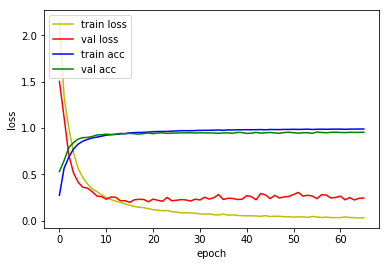

4815/4815 [==============================] - 13s 3ms/sample - loss: 0.2481 - acc: 0.9286
Loss: 0.24812673067873264 Accuracy: 0.9285566

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1064 - acc: 0.3063
Epoch 00001: val_loss improved from inf to 1.14343, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_8_conv_checkpoint/001-1.1434.hdf5
36805/36805 [==============================] - 273s 7ms/sample - loss: 2.1063 - acc: 0.3063 - val_loss: 1.1434 - val_acc: 0.6357
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1495 - acc: 0.6295
Epoch 00002: val_loss improved from 1.14343 to 0.75304, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_8_conv_checkpoint/002-0.7530.hdf5
36805/36805 [==============================] - 324s 9ms/sample - loss: 1.1496 - acc: 0.6295 - val_loss: 0.7530 - val_acc: 0.7640
Epoch 3/500
36800/36805 [============================

36800/36805 [============================>.] - ETA: 0s - loss: 0.1114 - acc: 0.9636
Epoch 00025: val_loss did not improve from 0.13880
36805/36805 [==============================] - 263s 7ms/sample - loss: 0.1116 - acc: 0.9635 - val_loss: 0.1602 - val_acc: 0.9553
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1018 - acc: 0.9656
Epoch 00026: val_loss did not improve from 0.13880
36805/36805 [==============================] - 319s 9ms/sample - loss: 0.1018 - acc: 0.9656 - val_loss: 0.1409 - val_acc: 0.9639
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0902 - acc: 0.9695
Epoch 00027: val_loss did not improve from 0.13880
36805/36805 [==============================] - 290s 8ms/sample - loss: 0.0903 - acc: 0.9695 - val_loss: 0.1412 - val_acc: 0.9644
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0898 - acc: 0.9700
Epoch 00028: val_loss did not improve from 0.13880
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0420 - acc: 0.9865
Epoch 00054: val_loss did not improve from 0.13375
36805/36805 [==============================] - 315s 9ms/sample - loss: 0.0420 - acc: 0.9865 - val_loss: 0.1520 - val_acc: 0.9653
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0423 - acc: 0.9861
Epoch 00055: val_loss did not improve from 0.13375
36805/36805 [==============================] - 290s 8ms/sample - loss: 0.0423 - acc: 0.9861 - val_loss: 0.1951 - val_acc: 0.9588
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0424 - acc: 0.9861
Epoch 00056: val_loss did not improve from 0.13375
36805/36805 [==============================] - 263s 7ms/sample - loss: 0.0424 - acc: 0.9861 - val_loss: 0.1632 - val_acc: 0.9665
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0373 - acc: 0.9879
Epoch 00057: val_loss did not improve from 0.13375
36805/36805 [=====================

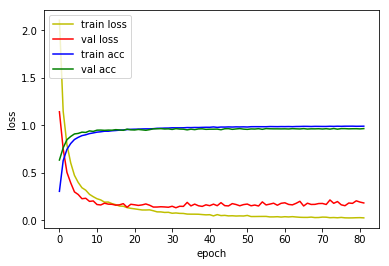

4815/4815 [==============================] - 13s 3ms/sample - loss: 0.1903 - acc: 0.9466
Loss: 0.19028238041455997 Accuracy: 0.9466251

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8180 - acc: 0.4144
Epoch 00001: val_loss improved from inf to 0.94824, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_9_conv_checkpoint/001-0.9482.hdf5
36805/36805 [==============================] - 289s 8ms/sample - loss: 1.8180 - acc: 0.4144 - val_loss: 0.9482 - val_acc: 0.7056
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9156 - acc: 0.7111
Epoch 00002: val_loss improved from 0.94824 to 0.57641, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_9_conv_checkpoint/002-0.5764.hdf5
36805/36805 [==============================] - 287s 8ms/sample - loss: 0.9155 - acc: 0.7111 - val_loss: 0.5764 - val_acc: 0.8085
Epoch 3/500
36800/36805 [============================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0743 - acc: 0.9752
Epoch 00025: val_loss improved from 0.13859 to 0.13162, saving model to model/checkpoint/1D_CNN_custom_kernel_192_ch_128_DO_9_conv_checkpoint/025-0.1316.hdf5
36805/36805 [==============================] - 286s 8ms/sample - loss: 0.0743 - acc: 0.9752 - val_loss: 0.1316 - val_acc: 0.9639
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0700 - acc: 0.9773
Epoch 00026: val_loss did not improve from 0.13162
36805/36805 [==============================] - 284s 8ms/sample - loss: 0.0700 - acc: 0.9773 - val_loss: 0.1337 - val_acc: 0.9620
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0639 - acc: 0.9790
Epoch 00027: val_loss did not improve from 0.13162
36805/36805 [==============================] - 283s 8ms/sample - loss: 0.0639 - acc: 0.9790 - val_loss: 0.1520 - val_acc: 0.9620
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss:

36800/36805 [============================>.] - ETA: 0s - loss: 0.0344 - acc: 0.9898
Epoch 00054: val_loss did not improve from 0.13162
36805/36805 [==============================] - 284s 8ms/sample - loss: 0.0344 - acc: 0.9898 - val_loss: 0.1658 - val_acc: 0.9672
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0273 - acc: 0.9914
Epoch 00055: val_loss did not improve from 0.13162
36805/36805 [==============================] - 284s 8ms/sample - loss: 0.0273 - acc: 0.9914 - val_loss: 0.1589 - val_acc: 0.9676
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0302 - acc: 0.9910
Epoch 00056: val_loss did not improve from 0.13162
36805/36805 [==============================] - 283s 8ms/sample - loss: 0.0301 - acc: 0.9910 - val_loss: 0.2018 - val_acc: 0.9618
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0275 - acc: 0.9918
Epoch 00057: val_loss did not improve from 0.13162
36805/36805 [=====================

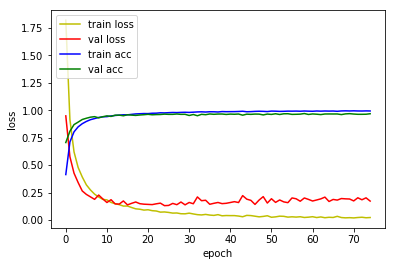

4815/4815 [==============================] - 14s 3ms/sample - loss: 0.2025 - acc: 0.9443
Loss: 0.2025076240811764 Accuracy: 0.9443406



In [10]:
for i in range(3, 10):
    base = '1D_CNN_custom_kernel_192_ch_128_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_ch_32_DO(conv_num=i)
    
    model = multi_gpu_model(model, gpus=2)
    
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_kernel_192_ch_128_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_kernel_192_ch_128_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_42_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 16)           6023568     lambda[0][0]                     
                                                            

4815/4815 [==============================] - 13s 3ms/sample - loss: 0.2481 - acc: 0.9286
Loss: 0.24812673067873264 Accuracy: 0.9285566

1D_CNN_custom_kernel_192_ch_128_DO_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_67_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 16000, 1)     0           conv1d_67_input[0][0]            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 16000, 1)     0           conv1d_67_input[0][0]            
__________________________________________________________________________________________________
sequential_12 (Sequentia

In [12]:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_kernel_192_ch_128_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_42_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 16)           6023568     lambda[0][0]                     
                                                            

4815/4815 [==============================] - 15s 3ms/sample - loss: 0.3100 - acc: 0.9398
Loss: 0.3099716586544375 Accuracy: 0.93977153

1D_CNN_custom_kernel_192_ch_128_DO_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_67_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 16000, 1)     0           conv1d_67_input[0][0]            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 16000, 1)     0           conv1d_67_input[0][0]            
__________________________________________________________________________________________________
sequential_12 (Sequentia